# How Do Stats Stabilize?
### MSP 05.11.2017

How large of a sample size do we need to trust a given statistic?

Building off of analyzing batting average, we want to take individual games and find out what range of games (or PAs, or ABs, or pitches) we have to consider in order to get a picture of who a player actually is.

### Part I: Hitting Ratios


In [1]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# boilerplate imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from random import randrange
import scipy.stats as sst




In [12]:
# now read in all the data: it's a lot, but is set up this way so that
#  we can slice across batting order.

#
# general fangraphs data for players
#
# all with > 100 PA at given lineup position

def read_batting_data(infile):
    BatData = np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","G","AB","PA","H",\
                                   "1B","2B","3B","HR","R","RBI","BB","IBB",
                                   "SO","HBP","SF","SH","GDP","SB","CS","AVG","playerid"),\
                         'formats': ('S20','S20','i2','f4','f4','f4',\
                                     'f4','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4','f4','f4','f4','i2')},\
                 skip_header=1,delimiter=',')
    return BatData


def read_individual_game_data(infile):
    BatData = np.genfromtxt(infile,\
                  dtype={'names': ("Date","Team","Opp","BO","Pos","G","AB","PA","H",\
                                   "1B","2B","3B","HR","R","RBI","BB","IBB",
                                   "SO","HBP","SF","SH","GDP","SB","CS","AVG"),\
                         'formats': ('S20','S20','S20','i2','S4','i2','f4','f4','f4',\
                                     'f4','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4','f4','f4','f4')},\
                 skip_header=2,delimiter=',')
    return BatData


Beltre2016 = read_individual_game_data('../batting_notebooks/2016Batting/BeltreLog2016.csv')
Trout2016 = read_individual_game_data('../batting_notebooks/2016Batting/TroutLog2016.csv')

Altuve2016 = read_individual_game_data('../batting_notebooks/2016Batting/AltuveLog2016.csv')
Altuve2017 = read_individual_game_data('../batting_notebooks/2016Batting/AltuveLog2017.csv')


Lemahieu2016 = read_individual_game_data('../batting_notebooks/2016Batting/LemahieuLog2016.csv')
Lemahieu2017 = read_individual_game_data('../batting_notebooks/2016Batting/LemahieuLog2017.csv')



Total2016   = read_batting_data('../batting_notebooks/2016Batting/TotalBatting.csv')



# the spreadsheet below has been adjusted to skip 'des', which routinely has commas. C'mon guys! This needs to be machine readable!
def read_statcast_data(infile):
    outdict = np.genfromtxt(infile,\
        dtype={'names': ("pitch_type","game_date",\
                         "release_speed","x0","z0","player_name","batter","pitcher",\
                         "events","description","spin_dir","spin_rate","break_angle",\
                         "break_length","zone","game_type","stand","p_throws",\
                         "home_team","away_team","type","hit_location","bb_type",\
                         "balls","strikes","game_year","pfx_x","pfx_z","px","pz",\
                         "on_3b","on_2b","on_1b","outs_when_up","inning","inning_topbot",\
                         "hc_x","hc_y","tfs","tfs_zulu","catcher","umpire","sv_id",\
                         "vx0","vy0","vz0","ax","ay","az","sz_top","sz_bot","hit_distance_sc",\
                         "launch_speed","launch_angle","effective_speed","release_spin_rate",\
                         "release_extension","game_pk",\
                         "pos1_id","pos2_id","pos3_id",\
                         "pos4_id","pos5_id","pos6_id",\
                         "pos7_id","pos8_id","pos9_id",\
                         "release_pos_y","estimated_ba_using_speedangle","estimated_woba_using_speedangle",\
                         "woba_value","woba_denom","babip_value","iso_value"),\
                'formats': ('S2','S20',\
                            'f4','S20','S20','S20','S20','S20',\
                            'S40','S40','S20','S20','S20',\
                            'S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20',\
                            'S20','S20','S20','f4','f4','f4','f4',\
                            'S20','S20','S20','S20','S20','S20',\
                            'f4','f4','S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20','S20','S20','S20','S20',\
                            'f4','f4','f4','f4',
                            'S20','S20',\
                            'f4','f4','f4',
                            'f4','f4','f4',
                            'f4','f4','f4',
                            'f4','f4','f4',
                            'f4','f4','f4','f4')},\
                 skip_header=1,delimiter=',')
    return outdict


AugustHits = read_statcast_data('../batting_notebooks/2016Batting/August2016Hits.csv')

AugustOuts = read_statcast_data('../batting_notebooks/2016Batting/August2016Outs.csv')






In [19]:
AugustOuts['player_name']

array(['Kendrys Morales', 'Eric Hosmer', 'Brett Gardner', ...,
       'Dee Gordon', 'Mookie Betts', 'Devon Travis'], 
      dtype='|S20')

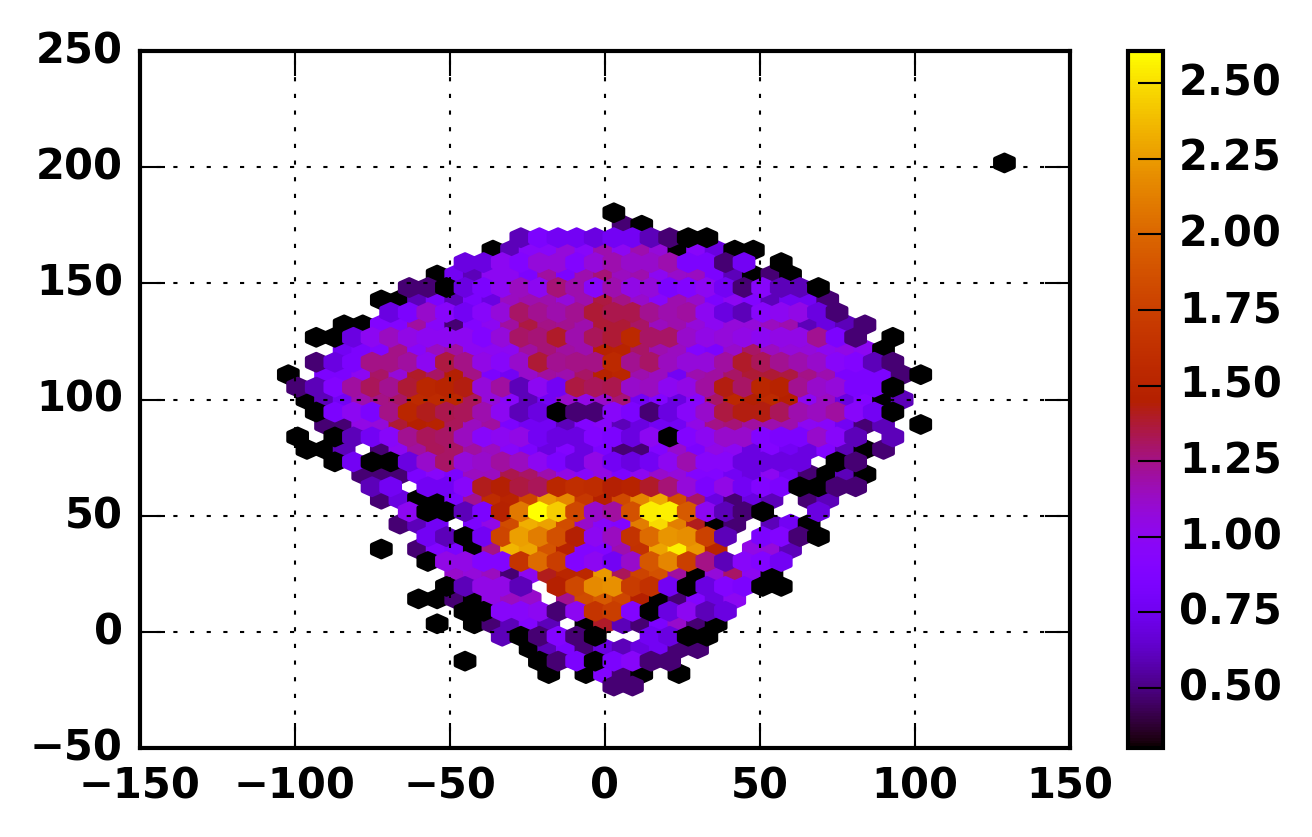

In [25]:

ghits = np.where( (AugustHits['launch_speed'] != 90) | (AugustHits['launch_angle'] > 0))[0]



#plt.scatter(128.-AugustHits['hc_x'],204.-AugustHits['hc_y'],color='black',s=1.)
#plt.scatter(128.-AugustOuts['hc_x'],204.-AugustOuts['hc_y'],color='red',s=0.2)


xbnds = np.array([-150.,150.])
ybnds = np.array([-50.,250.])
extent = [xbnds[0],xbnds[1],ybnds[0],ybnds[1]]

fig=plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
#x, y = points.T
# Set gridsize just to make them visually large
image = plt.hexbin(128.-AugustOuts['hc_x'],204.-AugustOuts['hc_y'],cmap=plt.cm.gnuplot,gridsize=50,extent=extent,mincnt=1,bins='log')

# Note that mincnt=1 adds 1 to each count
counts = image.get_array()
ncnts = np.count_nonzero(np.power(10,counts))
verts = image.get_offsets()
#for offc in xrange(verts.shape[0]):
#    binx,biny = verts[offc][0],verts[offc][1]
#    if counts[offc]:
#        plt.plot(binx,biny,'k.',zorder=100)

ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
plt.grid(True)
cb = plt.colorbar(image,spacing='uniform')#,extend='max')
plt.show()

A month ago we looked at what it took to make a home run in terms of launch angle and launch velocity (cue discussion of the statcast changeover). This is a plot of relative hit frequency (hits/outs) in the launch angle/launch velocity plane. 

Can we learn anything from looking at this?

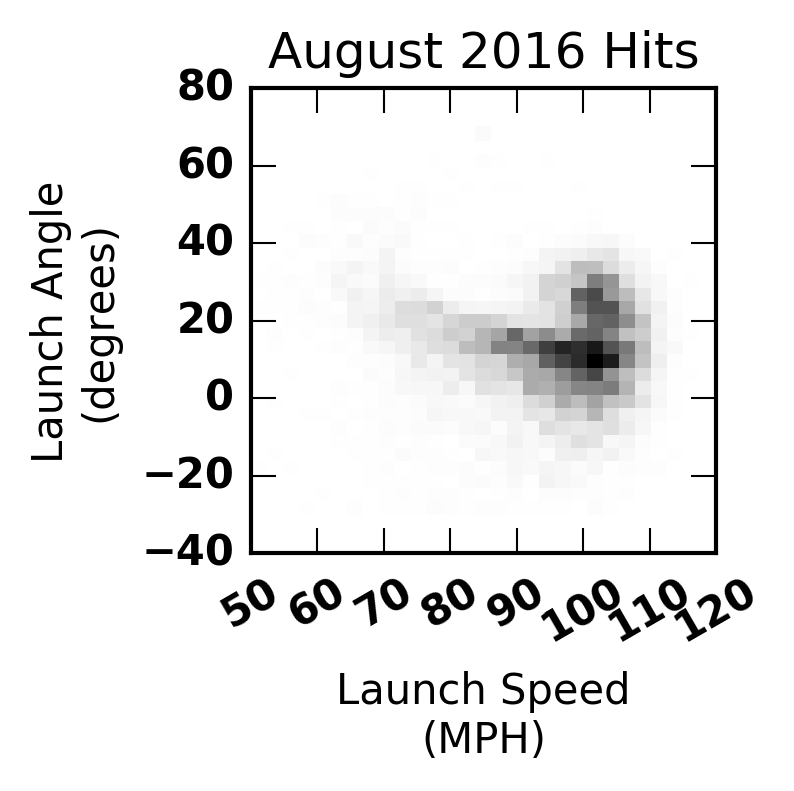

In [4]:

xbins = np.linspace(50.,120.,30)
ybins = np.linspace(-30.,70.,30)

ghits = np.where( (AugustHits['launch_speed'] != 90) | (AugustHits['launch_angle'] > 0))[0]

H, xedges, yedges = np.histogram2d(AugustHits['launch_speed'][ghits],AugustHits['launch_angle'][ghits], \
                                   bins=(xbins,ybins))
H = H.T/np.sum(H) # Let each row list bins with common y range.


ghits = np.where( (AugustOuts['launch_speed'] != 90) | (AugustOuts['launch_angle'] > 0))[0]

G, xedges, yedges = np.histogram2d(AugustOuts['launch_speed'][ghits],AugustOuts['launch_angle'][ghits], \
                                   bins=(xbins,ybins))
G = G.T/np.sum(G)  # Let each row list bins with common y range.



fig,ax = plt.subplots(figsize=(2,2))
ax.set_title('August 2016 Hits')
X, Y = np.meshgrid(xedges, yedges)
X2, Y2 = np.meshgrid(xbins,ybins)
ax.pcolormesh(X, Y, H/(G+1.),cmap=cm.Greys)
ax.set_ylabel('Launch Angle\n(degrees)')
ax.set_xlabel('Launch Speed\n(MPH)')

for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("center")



It seems like yes. I see two clear tracks in this plot, one where if you it it harder it's okay that the launch angle decreases, and by that same token, if you hit it hard enough, you've got a good shot at a hit no matter the angle (up to some tolerance, in this case about 40$^\circ$).

It's safe to roughly think of these as the single and extra base-hit tracks, and could be a jumping off point for some future analysis. For now, let's move on.

